<br>
I tried to implement distributed deep learning on the fashion mnist dataset.<br>
Our accelerator (NVIDIA T4 x 2) has two GPUs, and therefore it is suitable for a distributed learning algorithm.<br>

In [2]:
!pip install visualkeras

In [3]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import os
import visualkeras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# <span style="color:#e74c3c;"> Creating </span> Images DataFrame


In [4]:
datasets, info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True)
train, test = datasets['train'], datasets['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7AZN5O/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete7AZN5O/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# <span style="color:#e74c3c;"> Creating </span> TensorFlow Dataset

In [5]:
# Creating preprocessing function for dataset loader.
# read -> normalize

def img_preprocessing(image, label):
    
    img = tf.cast(image, tf.float32)/255.0
    #img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_flip_up_down(img)

    return img, label
    

In [6]:
# Creating train and test datasets

BATCH_SIZE_PER_COPY = 32
BATCH_SIZE = BATCH_SIZE_PER_COPY * 2 


train_dataset = (train.map(img_preprocessing).cache().batch(BATCH_SIZE).shuffle(10000).prefetch(BATCH_SIZE) )

test_dataset = (test.map(img_preprocessing).cache().batch(BATCH_SIZE).shuffle(10000).prefetch(BATCH_SIZE) )

# <span style="color:#e74c3c;"> CNN </span> Model

In [16]:
# Creating distribution strategy and the model

strategy = tf.distribute.MirroredStrategy()


with strategy.scope():
    inp = Input(shape = (28,28,1))
    
    X = Conv2D(64,3, activity_regularizer=tf.keras.regularizers.L2(1e-2))(inp)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = MaxPooling2D()(X)
    

    X = Flatten()(X)
    X = Dense(64, activation = 'relu')(X)
    out = Dense(10)(X)
    
 
    model = Model(inputs = inp, outputs = out)
    model.compile(optimizer = Adam() , loss = SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'] )
    model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0   

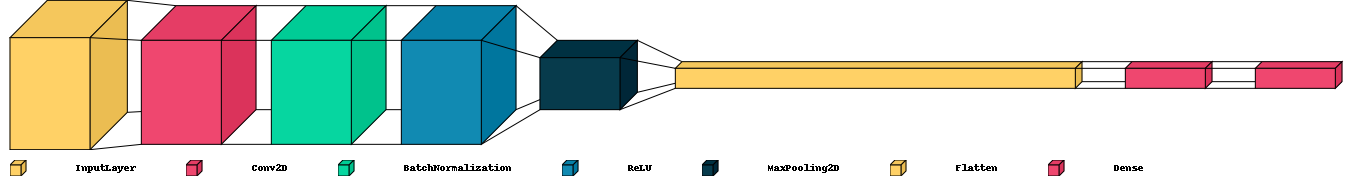

In [17]:
# The model visualization 

visualkeras.layered_view(model, legend = True, spacing = 50, min_z = 80, min_xy = 20)

In [18]:
# Training

model.fit(train_dataset, epochs = 30 , verbose = 1)

Epoch 1/30
938/938 [==============================] - 14s 11ms/step - loss: nan - accuracy: 0.8493
Epoch 2/30
938/938 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.8917
Epoch 3/30
938/938 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.9026
Epoch 4/30
938/938 [==============================] - 11s 11ms/step - loss: nan - accuracy: 0.9070
Epoch 5/30
938/938 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.9147
Epoch 6/30
938/938 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.9196
Epoch 7/30
938/938 [==============================] - 10s 11ms/step - loss: nan - accuracy: 0.9245
Epoch 8/30
938/938 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.9280
Epoch 9/30
938/938 [==============================] - 10s 10ms/step - loss: nan - accuracy: 0.9302
Epoch 10/30
938/938 [==============================] - 11s 11ms/step - loss: nan - accuracy: 0.9335
Epoch 11/

In [19]:
eval_test = model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(eval_test[1]*100))

157/157 [==============================] - 3s 7ms/step - loss: nan - accuracy: 0.8835
test accuracy : 88.350 %


In [21]:
example = test_dataset.take(1)

pred_ = model.predict(example)

pred_example = np.argmax(pred_, axis=1)

1/1 [==============================] - 0s 310ms/step


original label:  0
predict label:  0


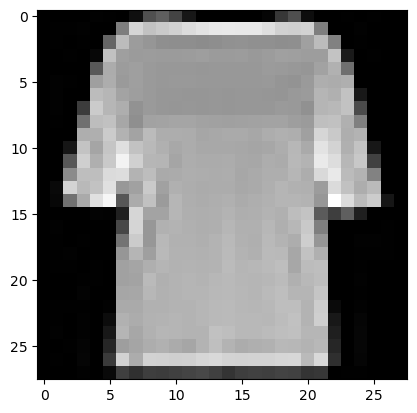

In [45]:
class_lookuptable = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' ]

ds = list(example)[0]

random_idx = random.randint(0, BATCH_SIZE-1)

img = ds[0][random_idx]
label = ds[1][random_idx].numpy()
predict_label = pred_example[random_idx]

print("original label: ", label )
print("predict label: ", predict_label )

plt.imshow(img, cmap = 'gray')